In [13]:
import torch
import sys
import numpy as np
import os
from glob import glob


device = torch.device("cpu")

# read .pt file
file_path = "results/butterscotch-cake-1265/map_two_rooms_horizontally_18_40/grid_length_7/activations/test/grid_observations_0/25/activation_grid_grid_observations_0_block_0.pt"
root_dir = "results/butterscotch-cake-1265/map_two_rooms_horizontally_18_40/grid_length_7/activations"

try:
    data = torch.load(file_path, map_location="cpu")
    print(f"Loaded type: {type(data)}")
    if isinstance(data, dict):
        print(f"Keys: {data.keys()}")
    elif isinstance(data, torch.Tensor):
        print(f"Tensor shape: {data.shape}")
    else:
        print("Loaded data:", data)
except Exception as e:
    print(f"Error loading file: {e}")

activation_files = sorted(glob(os.path.join(root_dir, "**/*.pt"), recursive=True))
print(f"Found {len(activation_files)} activation files")

Loaded type: <class 'torch.Tensor'>
Tensor shape: torch.Size([40, 30, 196])
Found 28 activation files


/tmp/ipykernel_942845/920049605.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path, map_location="cpu")


In [14]:
import torch
import os
import numpy as np
import re
from glob import glob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Regex pattern to extract grid observation and step
pattern = re.compile(r'grid_observations_(\d+)/(\d+)/activation_grid_grid_observations_\d+_block_(\d+).pt')

# Store activations and metadata
activation_data = []  # List of tuples (activations, grid_observation, step, block)

for file in activation_files:
    match = pattern.search(file)
    if match:
        grid_observation = int(match.group(1))
        step = int(match.group(2))
        block = int(match.group(3))
        
        # Load activation tensor
        tensor = torch.load(file, map_location="cpu")
        tensor = tensor.detach().numpy()  # Shape (40, 30, 196)

        # Store activations with metadata
        activation_data.append((tensor, grid_observation, step, block))

# Convert to a structured NumPy array
all_activations = np.concatenate([data[0] for data in activation_data], axis=0)  # Shape (N, 30, 196)
metadata = []
for data in activation_data:
    grid_observation, step, block = data[1], data[2], data[3]
    metadata.extend([(grid_observation, step, block)] * data[0].shape[0])  # Repeat for 40 activations


print(f"Combined activations shape: {all_activations.shape}")
print(f"Metadata count: {len(metadata)}")  # Should match the number of activations

# Reshape for clustering
X = all_activations.reshape(all_activations.shape[0], -1)  # Shape (N, 5880)


Combined activations shape: (2738, 30, 196)
Metadata count: 2738


/tmp/ipykernel_942845/1123641229.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file, map_location="cpu")


In [17]:
n_clusters = 2  # Adjust as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Store cluster results with metadata
cluster_results = [(metadata[i][0], metadata[i][1], metadata[i][2], labels[i]) for i in range(len(metadata))]

# Print some sample results
for i in range(5):
    print(f"Grid Obs {cluster_results[i][0]}, Step {cluster_results[i][1]}, Block {cluster_results[i][2]} -> Cluster {cluster_results[i][3]}")


Grid Obs 0, Step 150, Block 0 -> Cluster 1
Grid Obs 0, Step 150, Block 0 -> Cluster 0
Grid Obs 0, Step 150, Block 0 -> Cluster 0
Grid Obs 0, Step 150, Block 0 -> Cluster 0
Grid Obs 0, Step 150, Block 0 -> Cluster 1


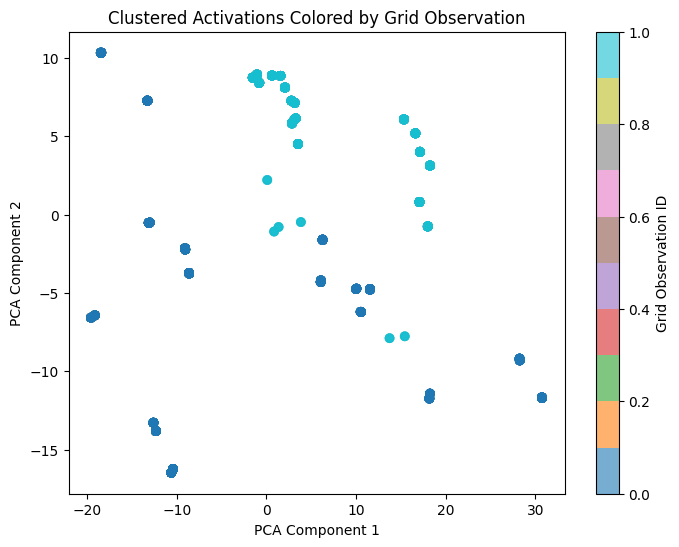

In [18]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Extract grid observation IDs for coloring
grid_obs_ids = np.array([meta[0] for meta in metadata[:X_pca.shape[0]]])  # Ensure length matches

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=grid_obs_ids, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label="Grid Observation ID")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustered Activations Colored by Grid Observation")
plt.show()


In [5]:
# Load all activation tensors
activation_tensors = []
for file in activation_files:
    tensor = torch.load(file, map_location="cpu")  # Load tensor
    tensor = tensor.detach().numpy()
    activation_tensors.append(tensor)  # Convert to numpy for clustering

all_activations = np.concatenate(activation_tensors, axis=0)
print(f"Combined activations shape: {all_activations.shape}")

Combined activations shape: (2738, 30, 196)


/tmp/ipykernel_942845/1301715929.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(file, map_location="cpu")  # Load tensor


In [6]:
# Reshape from (N, 30, 196) to (N, 30*196)
X = all_activations.reshape(all_activations.shape[0], -1)  # Shape (N, 5880)
print(f"Data reshaped for clustering: {X.shape}")

Data reshaped for clustering: (2738, 5880)


In [7]:
from sklearn.cluster import KMeans

n_clusters = 5  # Choose number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

print(f"Cluster assignments: {labels}")

Cluster assignments: [1 0 0 ... 3 3 3]


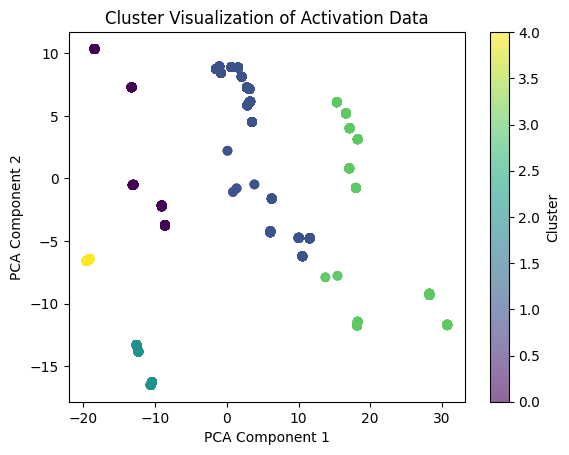

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization of Activation Data")
plt.show()